In [79]:
import numpy as np
import pandas as pd
import xarray as xr
import napari
import os
from skimage import io
import morphotrack.image
import morphotrack.points
import morphotrack.align
import pickle
from matplotlib import pyplot as plt

import importlib
importlib.reload(morphotrack.points)
# from scipy import spatial

<module 'morphotrack.points' from '/home/tmurakami/src/morphotrack/morphotrack/points.py'>

In [9]:
base_path = '/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03'
io_directory = os.path.join(base_path,'morphotrack')
track_ds = xr.open_dataset(os.path.join(io_directory,"track_ds.nc")).load()

In [32]:
# read images
imgs = {
    'nuclei': io.imread(os.path.join(io_directory,'R02_ch488_10um.tif')),
    'slc17a7': io.imread(os.path.join(io_directory,'R01_ch640_10um.tif')),
    'plp1': io.imread(os.path.join(io_directory,'R02_ch640_10um.tif')),
    'vessel': io.imread(os.path.join(io_directory,'R01_ch561_10um.tif')),
}


In [10]:
# read cellular coordinate
coord_path = {
    'slc17a7':os.path.join(base_path,'R01_R01/R01ch640_to_R01_segmentation','coord_centroids.csv'),
    'plp1':os.path.join(base_path,'R02_R01/R02ch640_to_R01_segmentation','coord_centroids.csv')
}

coords = {}
scaling_factor = np.asarray([3,0.65,0.65])
for key in coord_path:
    cells_info = pd.read_csv(coord_path[key],index_col=0) # the unit is original voxel.
    cell_coords = cells_info.loc[:,['centroid-0','centroid-1','centroid-2']] * scaling_factor / 10# convert unit to 10 um for consistency
    cell_coords = cell_coords.to_numpy()
    coords[key] = cell_coords

In [13]:
viewer = napari.Viewer()
# viewer.add_image(nuclei,colormap='gray',blending='additive')
viewer.add_points(
    coords['slc17a7'],
    size=2,
    face_color = 'white',
    edge_width=0,
    symbol='disc'
)

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


<Points layer 'Points' at 0x7f5514423370>

In [21]:
# selection of tracks based on the quality of the alignment
cond1 = track_ds.Similarity.sel(metrics='cs') >= track_ds.Similarity.attrs['cs_thresh']
cond2 = track_ds.Similarity.sel(metrics='mi') >= track_ds.Similarity.attrs['mi_thresh']
select_tracks = track_ds.track[cond1&cond2]
track_ds = track_ds.sel(track=select_tracks)

In [45]:
img = morphotrack.image.visualize_in_original_space(track_ds.Position, track_ds.Total_arg.sel(displacement='s2t'), nuclei.shape)

viewer = napari.Viewer()
viewer.add_image(img,colormap='turbo',blending='additive')
viewer.add_image(imgs['nuclei'],colormap='gray',blending='additive')
viewer.add_image(imgs['slc17a7'],colormap='gray',blending='additive')
points = viewer.add_points(
    track_ds.Seeds.data,
    features = track_ds.track.data, 
    size=10,
    face_color = 'white',
    edge_width=0,
    symbol='disc'
)

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [69]:
half_thickness = 2.5 # * 10 micrometer. half of the thickness
radius = 10 # * 10 micrometer

kernel_counts = morphotrack.points.count_around_position_in_disk_kernel(track_ds.Position, coords['plp1'], half_thickness, radius)
kernel_counts = kernel_counts.fillna(0)

In [70]:
t2s_non_linear_warped = morphotrack.align.positional_mapping(kernel_counts*track_ds.Gray_loc, track_ds.Total_arg.sel(displacement='t2s'))

In [72]:
viewer = napari.Viewer()
viewer.add_image(track_ds.Gray_counts,colormap='green',blending='additive',visible=False)
viewer.add_image(track_ds.Standard,colormap='green',blending='additive')
viewer.add_image(t2s_non_linear_warped,colormap='magenta',blending='additive')
viewer.add_image(track_ds.Total_warped.sel(displacement='t2s'),colormap='magenta',blending='additive')

<Image layer 'Image [2]' at 0x7f555b8f8d30>

In [76]:
reference_time = 170 # time corresponding to layer IV is a good choice.
ref_time_in_standard = track_ds.Total_arg.sel(displacement='t2s').sel(time=reference_time)
layer_position = []
for ti, tr in zip(ref_time_in_standard.data,ref_time_in_standard.track.data):
    layer_position.append(track_ds.Position.sel(track=tr).interp(time=ti))
layer_position = xr.concat(layer_position,dim='track')

clf = pickle.load(open(os.path.join(io_directory,'model.pkl'), 'rb'))
norm_flow_on_coordinate = morphotrack.points.model_to_get_flow_func(clf.degree, clf)
local_flux = morphotrack.points.get_local_flux(layer_position.data, norm_flow_on_coordinate, radius)

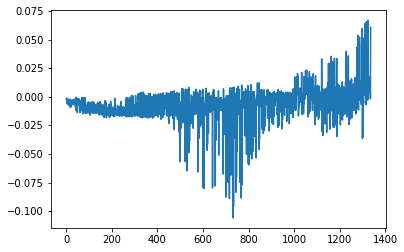

In [80]:
plt.plot(local_flux)